# Orientações para o trabalho final

A idéia desta atividade é realizar a paralelização de uma aplicação ou comparação entre plataformas usando algumas das estratégias apresentadas no curso.  O problema não é fixo, fica à escolha, mas tem que tratar de um problema com complexidade ou volume de processamento relevante. Exemplos de problema incluem [Stencils](https://en.wikipedia.org/wiki/Stencil_code), [String matching](https://en.wikipedia.org/wiki/String-searching_algorithm) e [ordenação](https://en.wikipedia.org/wiki/Sorting_algorithm), entre outros. Resumidamente, os passos para o desenvolvimento do trabalho são os seguintes:

1. Encontre e clone ou crie um repositório com o código que queira trabalhar;
2. Execute o código inicial e salve os resultados obtidos;
3. Faça as modificações que desejar para otimizar o código ou comparar seu desempenho entre diferentes arquiteturas/plataformas;
4. Execute cada versão que julgar relevante salvando os resultados obtidos;
5. Elabore um gráfico comparativo das versões;
6. Elebore um relatório com a discussão dos resultados no README.md na raiz, contendo:
  - Descrição do problema;
  - Estratégia de paralelização;
  - Versão sequencial de referência (apenas trecho de interesse para paralelização);
  - Versão paralela comentada (apenas trecho de interesse de paralelização);
  - Análise da escalabilidade: esperada e obtida;
  - Discussão sobre a eficiência da solução;
  - Conclusões;
7. Envie o link do repositório para correção. 

O repositório no GitHub, com o material desenvolvido, deve conter:
- O código inicial (para sabermos de onde você partiu);
- Commits/Releases para versões modificadas;
- Comparativo entre elas incluindo gráficos e discussão.

In [ ]:
Configurações de hardware usadas para execução

In [343]:
!lscpu

Architecture:        x86_64
CPU op-mode(s):      32-bit, 64-bit
Byte Order:          Little Endian
Address sizes:       36 bits physical, 48 bits virtual
CPU(s):              4
On-line CPU(s) list: 0-3
Thread(s) per core:  1
Core(s) per socket:  4
Socket(s):           1
Vendor ID:           GenuineIntel
CPU family:          6
Model:               94
Model name:          Intel(R) Core(TM) i5-6500 CPU @ 3.20GHz
Stepping:            3
CPU MHz:             3201.000
CPU max MHz:         3201.0000
BogoMIPS:            6402.00
Virtualization:      VT-x
Hypervisor vendor:   Windows Subsystem for Linux
Virtualization type: container
Flags:               fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cm
                     ov pat pse36 clflush dts acpi mmx fxsr sse sse2 ss ht tm pb
                     e syscall nx pdpe1gb rdtscp lm pni pclmulqdq dtes64 monitor
                      ds_cpl vmx smx est tm2 ssse3 fma cx16 xtpr pdcm pcid sse4_
                     1 sse4_2 x2apic movbe p

Script para gerar arrays suficientemente grandes para medir o desempenho

In [395]:
#Gerar vetores de tamanho N
import random

#Definir tamanho do vetor
n = 100000

f = open('v.in', 'w')

f.write(str(n) + '\n')

for i in range(n):
      f.write(str(random.randint(-10000, 10000)) + ' ')
      
f.close()

Compilação

In [ ]:
!if [ ! mergesort -nt mergesort.c ]; then gcc mergesort.c -o mergesort -O3; fi
!time ./mergesort < v.in > seq.out

In [ ]:
!if [ ! mergesortOMP -nt mergesortOMP.c ]; then gcc mergesortOMP.c -o mergesortOMP -fopenmp -O3; fi
!time ./mergesortOMP < v.in > par.out

In [ ]:
! if [ ! mergesortCUDA -nt mergesortCUDA.cu ]; then nvcc mergesortCUDA.cu -w -o mergesortCUDA -O3 ; fi
! time ./mergesortCUDA < v.in > cuda.out

In [340]:
!diff seq.out par.out

In [358]:
!rm seq.out && rm par.out && rm cuda.out

Tempos de execução do código

In [402]:
%%writefile tempos.csv
platform, version, execution_time_s
CPU, Serial, 0.252
CPU, Serial, 0.402
CPU, Serial, 0.360
CPU, Serial, 0.366
CPU, Serial, 0.369
CPU P, Paralelo, 0.216
CPU P, Paralelo, 0.212
CPU P, Paralelo, 0.219
CPU P, Paralelo, 0.212
CPU P, Paralelo, 0.217
GPU, Paralelo, 0.198
GPU, Paralelo, 0.201
GPU, Paralelo, 0.248
GPU, Paralelo, 0.198
GPU, Paralelo, 0.194

Writing tempos.csv


O foco da paralelização foi a função mergeSort que divide o vetor em 2 partes e invoca a si mesmo e faz um merge das subdivisões.

Sua versão sequencial é a seguinte:

```c
//Merge sort  Sequencial
    void mergeSort(int arr[], int l, int r)
{
	if (l < r) {
		int m = l + (r - l) / 2;

		mergeSort(arr, l, m);
		mergeSort(arr, m + 1, r);

		merge(arr, l, m, r);
	}
}
```
Com OpenMP criamos seções paralelas para serem executadas por threads:

```c
//Paralelização do mergeSort com OpenMP
void mergeSort(int arr[], int l, int r)
{	
	int m;
	if (l < r) {

		int m = l + (r - l) / 2;
		//Seção paralela que se subdividirá em 2 seções para cala lado do merge
		#pragma omp parallel sections num_threads(2)
		{
			#pragma omp section
			{
				mergeSort(arr, l, m);
			}

			#pragma omp section
			{
				mergeSort(arr, m + 1, r);
			}
		}
		merge(arr, l, m, r);
	}
}
```

Com CUDA criamos a função no host para realizar a operação na GPU:

```c
//Criação da função no kernel
__global__ void mergeSort(int arr[], int l, int r)
{
    if (l < r) {
        int m = l + (r - l) / 2;
        mergeSort<<<1,1>>>(arr, l, m);
        mergeSort<<<1,1>>>(arr, m + 1, r);
        merge(arr, l, m, r);
    }
}
```

/tmp/ipykernel_2047/161060906.py:11: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  avg_time = by_version.mean()
/tmp/ipykernel_2047/161060906.py:12: FutureWarning: The default value of numeric_only in DataFrameGroupBy.std is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  std = by_version.std()


Text(0, 0.5, 'Execution time (s)')

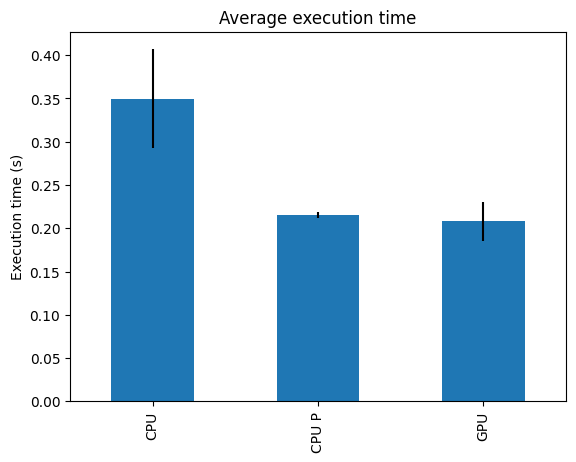

In [403]:
import os
import pandas as pd
import matplotlib.pyplot as plt

FILENAME = 'tempos.csv'

if os.path.isfile(FILENAME):
    df = pd.read_csv(FILENAME)

by_version = df.groupby(by="platform", sort=False)
avg_time = by_version.mean()
std = by_version.std()
plt = avg_time.plot(legend=False, kind="bar", yerr=std, xlabel="")
plt.set_title("Average execution time")
plt.set_ylabel("Execution time (s)")